# BLR

Study of deconvolution algorithms

In [1]:
from __future__ import print_function
from IPython.display import Image
%matplotlib inline

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [6]:
import pandas as pd
import tables as tb
import numpy as np
import tables

In [7]:
from system_of_units import *

In [8]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

In [9]:
from Configure import configure
from cities import isidora

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import mplFunctions as mpl
import wfmFunctions as wfm
import tblFunctions as tbl

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

### BLR

#### Deconvolution function

In [48]:
class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = 0, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
    
    logging.debug("sblr.signal_r[0:10]= {}".format(sblr.signal_r[0:10]))
    logging.debug("BASELINE ={}".format(sblr.BASELINE))
                       
    sblr.signal_r = sblr.signal_r - sblr.BASELINE
    
    logging.debug("sblr.signal_r[0:10] - BASELINE= {}".format(sblr.signal_r[0:10]))
   
    return  sblr

def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sblr = BLR(pmtrd[event_number, j], coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS


### ISIDORA

In [12]:
def ISIDORA(argv):
    DEBUG_LEVEL, INFO, CFP = configure(argv[0],argv[1:])
    if INFO:
        print(isidora)

    #wait()
    
    print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    
    PATH_IN=CFP['PATH_IN'] 
    FILE_IN=CFP['FILE_IN']
    FIRST_EVT=CFP['FIRST_EVT']
    LAST_EVT=CFP['LAST_EVT']
    RUN_ALL=CFP['RUN_ALL']
    COEF=CFP['COEF']
    CA=farray_from_string(CFP['CA'])*nF 
    AC=farray_from_string(CFP['AC']) 
    MAU_LEN=CFP['MAU_LEN']
    NSIGMA1=CFP['NSIGMA1'] 
    NSIGMA2=CFP['NSIGMA2'] 

    NEVENTS = LAST_EVT -  FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("MAU length = {} n_sigma1 = {} n_sigma2 = {} ".format(
        MAU_LEN,NSIGMA1,NSIGMA2))
    logger.info("CA sigma(nf) = {}  ".format(CA/nF))
    

    # open the input file in mode append 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "a") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.RD.pmtrwf

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)    
        
        NPMT = pmtrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof events in input DST = {} ".format(
        NPMT,NEVENTS_DST))

        logger.info("lof PMT WF (MC) = {} ".format(
        PMTWL))

        #wait()
            
        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        pmtcwf =0
        try:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration (por PMT0)

        rgroup = 0
        try:
            rgroup = h5in.root.BLR
            
        except tables.exceptions.NodeError:
            rgroup = h5in.create_group(h5in.root, "BLR")

        
        mau = 0
        acum = 0
        pulse_on = 0
        wait_over = 0
        baseline = 0

        try:
            mau = h5in.root.BLR.mau
            h5in.remove_node("/BLR","mau")
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            pulse_on = h5in.root.BLR.pulse_on
            h5in.remove_node("/BLR","pulse_on")
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            wait_over = h5in.root.BLR.wait_over
            h5in.remove_node("/BLR","wait_over")
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            acum  = h5in.root.BLR.acum 
            h5in.remove_node("/BLR","acum")
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            baseline  = h5in.root.BLR.baseline 
            h5in.remove_node("/BLR","baseline")
            baseline  = h5in.create_earray(h5in.root.BLR, "baseline", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            baseline  = h5in.create_earray(h5in.root.BLR, "baseline", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)

            
        if NEVENTS > NEVENTS_DST and RUN_ALL == False:
            print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
            sys.exit(0)

        elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
            FIRST_EVT = 0
            LAST_EVT = NEVENTS_DST
            NEVENTS = NEVENTS_DST

            
        for i in range(FIRST_EVT,LAST_EVT):
            
            logger.info("-->event number ={}".format(i))

            #DBLR
            coeff_acc = AC
            if COEF == 0:
                coeff_acc = accumulator_coefficients(pmtrd_,CA)


            BLRS = DBLR(pmtrd_, i, coeff_acc, mau_len=MAU_LEN,
                        thr1 = NSIGMA1*FP.NOISE_ADC, thr2=0, 
                        thr3 = NSIGMA2*FP.NOISE_ADC, log=DEBUG_LEVEL)

            
            pmtCWF = []
            for blr in BLRS:
                pmtCWF.append(blr.signal_r)
                
            #append to pmtcwd
            pmtcwf.append(np.array(pmtCWF).reshape(1, NPMT, PMTWL))

            # append BLR variables
            
            
            BASELINE = []
            for blr in BLRS:
                BASELINE.append(blr.BASELINE)
            baseline.append(np.array(BASELINE).reshape(1, NPMT))

            mau_pmt0 = BLRS[0].MAU
            mau.append(mau_pmt0.reshape(1, PMTWL))

            pulse_on0 = BLRS[0].pulse_on
            pulse_on.append(pulse_on0.reshape(1, PMTWL))

            wait_over0 = BLRS[0].wait_over
            wait_over.append(wait_over0.reshape(1, PMTWL))

            acum0  = BLRS[0].acum
            acum.append(acum0.reshape(1, PMTWL))
                
                
        pmtcwf.flush()
        mau.flush()
        pulse_on.flush()
        wait_over.flush()
        acum.flush()
        baseline.flush()
        

    print("Leaving Isidora. Safe travels!")


In [ ]:
%less ../../Config/ISIDORA_NA_ZLIB_test.csv

In [13]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+") 

In [14]:
pmtrwf = h5f.root.RD.pmtrwf

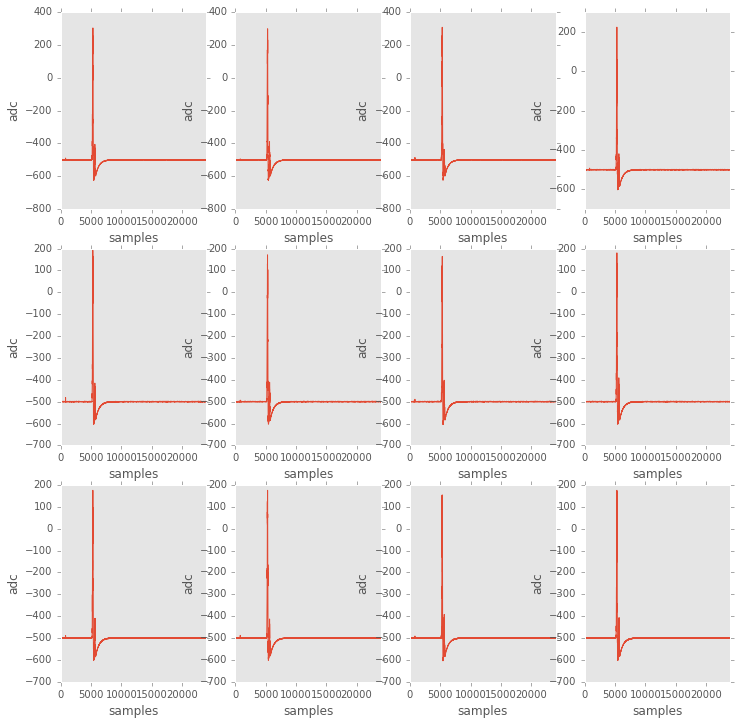

In [15]:
plot_waveforms(pmtrwf[0]) 

In [46]:
h5f.close()

In [49]:
ISIDORA(['-i','-d','DEBUG','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA1': 3.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}


Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA1': 3.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}



        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        
Debug level = DEBUG
INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


INFO:root:first event = 0 last event = 10 nof events requested = 10 


first event = 0 last event = 10 nof events requested = 10 


INFO:root:MAU length = 250 n_sigma1 = 3.0 n_sigma2 = 1.0 


MAU length = 250 n_sigma1 = 3.0 n_sigma2 = 1.0 


INFO:root:CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


INFO:root:nof PMTs = 12 nof events in input DST = 100 


nof PMTs = 12 nof events in input DST = 100 


INFO:root:lof PMT WF (MC) = 24000 


lof PMT WF (MC) = 24000 


INFO:root:-->event number =0


-->event number =0


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.532


n = 250, acum[n] = 0.0 BASELINE =-499.532


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -499. -500. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -499. -500. -500. -499.]


DEBUG:root:BASELINE =-499.532


BASELINE =-499.532


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.468  0.532 -0.468 -0.468  0.532  0.532  0.532 -0.468 -0.468  0.532]


sblr.signal_r[0:10] - BASELINE= [-0.468  0.532 -0.468 -0.468  0.532  0.532  0.532 -0.468 -0.468  0.532]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.468


n = 250, acum[n] = 0.0 BASELINE =-499.468


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -499. -499. -499. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -499. -499. -499. -499. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.468


BASELINE =-499.468


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.532 -0.532  0.468  0.468  0.468  0.468  0.468 -0.532  0.468  0.468]


sblr.signal_r[0:10] - BASELINE= [-0.532 -0.532  0.468  0.468  0.468  0.468  0.468 -0.532  0.468  0.468]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.544


n = 250, acum[n] = 0.0 BASELINE =-499.544


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -500. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -500. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.544


BASELINE =-499.544


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.544  0.544 -0.456 -0.456  0.544 -0.456 -0.456  0.544 -0.456 -0.456]


sblr.signal_r[0:10] - BASELINE= [ 0.544  0.544 -0.456 -0.456  0.544 -0.456 -0.456  0.544 -0.456 -0.456]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.492


n = 250, acum[n] = 0.0 BASELINE =-499.492


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -499. -500. -499. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -499. -499. -500. -499. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.492


BASELINE =-499.492


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.508 -0.508  0.492  0.492 -0.508  0.492  0.492  0.492  0.492  0.492]


sblr.signal_r[0:10] - BASELINE= [-0.508 -0.508  0.492  0.492 -0.508  0.492  0.492  0.492  0.492  0.492]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -499. -499. -500. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -499. -499. -500. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484  0.484  0.484  0.484 -0.516  0.484  0.484  0.484 -0.516]


sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484  0.484  0.484  0.484 -0.516  0.484  0.484  0.484 -0.516]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -501. -500. -500. -500. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -501. -500. -500. -500. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.464  0.464 -1.536 -0.536 -0.536 -0.536  0.464  0.464  0.464 -0.536]


sblr.signal_r[0:10] - BASELINE= [ 0.464  0.464 -1.536 -0.536 -0.536 -0.536  0.464  0.464  0.464 -0.536]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -500. -499. -499. -500. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -500. -499. -500. -499. -499. -500. -499. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.536 -0.536  0.464 -0.536  0.464  0.464 -0.536  0.464 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [-0.536 -0.536  0.464 -0.536  0.464  0.464 -0.536  0.464 -0.536  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.424


n = 250, acum[n] = 0.0 BASELINE =-499.424


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.424


BASELINE =-499.424


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.576  0.424  0.424  0.424 -0.576 -0.576  0.424 -0.576  0.424  0.424]


sblr.signal_r[0:10] - BASELINE= [-0.576  0.424  0.424  0.424 -0.576 -0.576  0.424 -0.576  0.424  0.424]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.536


n = 250, acum[n] = 0.0 BASELINE =-499.536


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.536


BASELINE =-499.536


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.464  0.536 -0.464 -0.464  0.536 -0.464  0.536  0.536 -0.464  0.536]


sblr.signal_r[0:10] - BASELINE= [-0.464  0.536 -0.464 -0.464  0.536 -0.464  0.536  0.536 -0.464  0.536]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.536


n = 250, acum[n] = 0.0 BASELINE =-499.536


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -500. -500. -499. -500. -499. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -500. -500. -499. -500. -499. -500.]


DEBUG:root:BASELINE =-499.536


BASELINE =-499.536


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.464 -0.464 -0.464  0.536 -0.464 -0.464  0.536 -0.464  0.536 -0.464]


sblr.signal_r[0:10] - BASELINE= [-0.464 -0.464 -0.464  0.536 -0.464 -0.464  0.536 -0.464  0.536 -0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.428


n = 250, acum[n] = 0.0 BASELINE =-499.428


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -499. -500. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -499. -500. -499. -500.]


DEBUG:root:BASELINE =-499.428


BASELINE =-499.428


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.428  0.428  0.428 -0.572  0.428  0.428  0.428 -0.572  0.428 -0.572]


sblr.signal_r[0:10] - BASELINE= [ 0.428  0.428  0.428 -0.572  0.428  0.428  0.428 -0.572  0.428 -0.572]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -499. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -499. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.536  0.464  0.464 -0.536  0.464  0.464  0.464  0.464 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [-0.536  0.464  0.464 -0.536  0.464  0.464  0.464  0.464 -0.536  0.464]


INFO:root:-->event number =1


-->event number =1


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.5


n = 250, acum[n] = 0.0 BASELINE =-499.5


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -499. -500. -500. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -499. -500. -500. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.5


BASELINE =-499.5


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0.5]


sblr.signal_r[0:10] - BASELINE= [ 0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0.5]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.536 -0.536 -0.536  0.464  0.464  0.464 -0.536 -0.536  0.464  0.464]


sblr.signal_r[0:10] - BASELINE= [-0.536 -0.536 -0.536  0.464  0.464  0.464 -0.536 -0.536  0.464  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.524


n = 250, acum[n] = 0.0 BASELINE =-499.524


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.524


BASELINE =-499.524


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.476  0.524 -0.476  0.524  0.524 -0.476  0.524  0.524 -0.476  0.524]


sblr.signal_r[0:10] - BASELINE= [-0.476  0.524 -0.476  0.524  0.524 -0.476  0.524  0.524 -0.476  0.524]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.508


n = 250, acum[n] = 0.0 BASELINE =-499.508


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -500. -499. -499. -500. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -500. -499. -499. -500. -500. -500.]


DEBUG:root:BASELINE =-499.508


BASELINE =-499.508


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.508  0.508  0.508 -0.492 -0.492  0.508  0.508 -0.492 -0.492 -0.492]


sblr.signal_r[0:10] - BASELINE= [ 0.508  0.508  0.508 -0.492 -0.492  0.508  0.508 -0.492 -0.492 -0.492]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.448


n = 250, acum[n] = 0.0 BASELINE =-499.448


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -500. -499. -500. -500. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -500. -499. -500. -500. -499. -500.]


DEBUG:root:BASELINE =-499.448


BASELINE =-499.448


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.448 -0.552  0.448  0.448 -0.552  0.448 -0.552 -0.552  0.448 -0.552]


sblr.signal_r[0:10] - BASELINE= [ 0.448 -0.552  0.448  0.448 -0.552  0.448 -0.552 -0.552  0.448 -0.552]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.432


n = 250, acum[n] = 0.0 BASELINE =-499.432


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -500. -500. -499. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -500. -500. -499. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.432


BASELINE =-499.432


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.432 -0.568  0.432 -0.568 -0.568  0.432 -0.568 -0.568  0.432  0.432]


sblr.signal_r[0:10] - BASELINE= [ 0.432 -0.568  0.432 -0.568 -0.568  0.432 -0.568 -0.568  0.432  0.432]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.472


n = 250, acum[n] = 0.0 BASELINE =-499.472


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.472


BASELINE =-499.472


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.528  0.472 -0.528 -0.528  0.472  0.472 -0.528 -0.528  0.472  0.472]


sblr.signal_r[0:10] - BASELINE= [-0.528  0.472 -0.528 -0.528  0.472  0.472 -0.528 -0.528  0.472  0.472]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -499. -499. -499. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -499. -499. -499. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484 -0.516  0.484  0.484  0.484  0.484  0.484 -0.516  0.484]


sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484 -0.516  0.484  0.484  0.484  0.484  0.484 -0.516  0.484]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.52


n = 250, acum[n] = 0.0 BASELINE =-499.52


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -499. -500. -499. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -499. -500. -499. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.52


BASELINE =-499.52


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.52  0.52  0.52  0.52 -0.48  0.52  0.52  0.52  0.52 -0.48]


sblr.signal_r[0:10] - BASELINE= [ 0.52  0.52  0.52  0.52 -0.48  0.52  0.52  0.52  0.52 -0.48]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.552


n = 250, acum[n] = 0.0 BASELINE =-499.552


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -499. -500. -499. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -499. -500. -499. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.552


BASELINE =-499.552


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.552  0.552  0.552  0.552 -0.448  0.552  0.552  0.552  0.552 -0.448]


sblr.signal_r[0:10] - BASELINE= [ 0.552  0.552  0.552  0.552 -0.448  0.552  0.552  0.552  0.552 -0.448]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.5


n = 250, acum[n] = 0.0 BASELINE =-499.5


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.5


BASELINE =-499.5


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.5 -0.5 -0.5  0.5  0.5  0.5 -0.5  0.5 -0.5 -0.5]


sblr.signal_r[0:10] - BASELINE= [-0.5 -0.5 -0.5  0.5  0.5  0.5 -0.5  0.5 -0.5 -0.5]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.532


n = 250, acum[n] = 0.0 BASELINE =-499.532


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -500. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -500. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.532


BASELINE =-499.532


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.532  0.532 -0.468 -0.468  0.532 -0.468 -0.468 -0.468  0.532  0.532]


sblr.signal_r[0:10] - BASELINE= [ 0.532  0.532 -0.468 -0.468  0.532 -0.468 -0.468 -0.468  0.532  0.532]


INFO:root:-->event number =2


-->event number =2


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.524


n = 250, acum[n] = 0.0 BASELINE =-499.524


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -500. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -500. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.524


BASELINE =-499.524


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.476 -0.476 -0.476 -0.476 -0.476 -0.476  0.524  0.524  0.524  0.524]


sblr.signal_r[0:10] - BASELINE= [-0.476 -0.476 -0.476 -0.476 -0.476 -0.476  0.524  0.524  0.524  0.524]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.468


n = 250, acum[n] = 0.0 BASELINE =-499.468


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -499. -499. -499. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -499. -499. -499. -499. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.468


BASELINE =-499.468


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.532 -0.532  0.468  0.468  0.468  0.468 -0.532  0.468 -0.532 -0.532]


sblr.signal_r[0:10] - BASELINE= [-0.532 -0.532  0.468  0.468  0.468  0.468 -0.532  0.468 -0.532 -0.532]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.548


n = 250, acum[n] = 0.0 BASELINE =-499.548


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -500. -499. -499. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -499. -500. -499. -499. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.548


BASELINE =-499.548


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.452 -0.452  0.548 -0.452  0.548  0.548  0.548 -0.452  0.548  0.548]


sblr.signal_r[0:10] - BASELINE= [-0.452 -0.452  0.548 -0.452  0.548  0.548  0.548 -0.452  0.548  0.548]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.44


n = 250, acum[n] = 0.0 BASELINE =-499.44


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -499. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -499. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.44


BASELINE =-499.44


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.44 -0.56 -0.56 -0.56  0.44  0.44 -0.56 -0.56 -0.56  0.44]


sblr.signal_r[0:10] - BASELINE= [ 0.44 -0.56 -0.56 -0.56  0.44  0.44 -0.56 -0.56 -0.56  0.44]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.448


n = 250, acum[n] = 0.0 BASELINE =-499.448


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -499. -500. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -499. -500. -499. -500. -499.]


DEBUG:root:BASELINE =-499.448


BASELINE =-499.448


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.448  0.448 -0.552 -0.552  0.448  0.448 -0.552  0.448 -0.552  0.448]


sblr.signal_r[0:10] - BASELINE= [ 0.448  0.448 -0.552 -0.552  0.448  0.448 -0.552  0.448 -0.552  0.448]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -499. -499. -499. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -499. -499. -499. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.484 -0.516 -0.516  0.484  0.484  0.484 -0.516  0.484  0.484  0.484]


sblr.signal_r[0:10] - BASELINE= [ 0.484 -0.516 -0.516  0.484  0.484  0.484 -0.516  0.484  0.484  0.484]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.516


n = 250, acum[n] = 0.0 BASELINE =-499.516


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.516


BASELINE =-499.516


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.516  0.516 -0.484 -0.484 -0.484 -0.484 -0.484 -0.484  0.516  0.516]


sblr.signal_r[0:10] - BASELINE= [ 0.516  0.516 -0.484 -0.484 -0.484 -0.484 -0.484 -0.484  0.516  0.516]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.496


n = 250, acum[n] = 0.0 BASELINE =-499.496


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.496


BASELINE =-499.496


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.496  0.496 -0.504 -0.504 -0.504 -0.504 -0.504 -0.504  0.496  0.496]


sblr.signal_r[0:10] - BASELINE= [ 0.496  0.496 -0.504 -0.504 -0.504 -0.504 -0.504 -0.504  0.496  0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.5


n = 250, acum[n] = 0.0 BASELINE =-499.5


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -499. -501. -500. -500. -499. -500. -498.]


sblr.signal_r[0:10]= [-500. -499. -500. -499. -501. -500. -500. -499. -500. -498.]


DEBUG:root:BASELINE =-499.5


BASELINE =-499.5


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.5  0.5 -0.5  0.5 -1.5 -0.5 -0.5  0.5 -0.5  1.5]


sblr.signal_r[0:10] - BASELINE= [-0.5  0.5 -0.5  0.5 -1.5 -0.5 -0.5  0.5 -0.5  1.5]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.508


n = 250, acum[n] = 0.0 BASELINE =-499.508


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -499. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -499. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.508


BASELINE =-499.508


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.508 -0.492 -0.492 -0.492  0.508  0.508  0.508 -0.492  0.508  0.508]


sblr.signal_r[0:10] - BASELINE= [ 0.508 -0.492 -0.492 -0.492  0.508  0.508  0.508 -0.492  0.508  0.508]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.552


n = 250, acum[n] = 0.0 BASELINE =-499.552


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -499. -500. -499. -500. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -500. -499. -500. -499. -500. -499. -499. -500.]


DEBUG:root:BASELINE =-499.552


BASELINE =-499.552


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.552  0.552 -0.448  0.552 -0.448  0.552 -0.448  0.552  0.552 -0.448]


sblr.signal_r[0:10] - BASELINE= [ 0.552  0.552 -0.448  0.552 -0.448  0.552 -0.448  0.552  0.552 -0.448]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.56


n = 250, acum[n] = 0.0 BASELINE =-499.56


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -499. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -499. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.56


BASELINE =-499.56


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.44  0.56  0.56  0.56  0.56  0.56 -0.44 -0.44 -0.44  0.56]


sblr.signal_r[0:10] - BASELINE= [-0.44  0.56  0.56  0.56  0.56  0.56 -0.44 -0.44 -0.44  0.56]


INFO:root:-->event number =3


-->event number =3


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.436


n = 250, acum[n] = 0.0 BASELINE =-499.436


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -499. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -499. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.436


BASELINE =-499.436


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.564  0.436 -0.564  0.436  0.436  0.436 -0.564  0.436  0.436  0.436]


sblr.signal_r[0:10] - BASELINE= [-0.564  0.436 -0.564  0.436  0.436  0.436 -0.564  0.436  0.436  0.436]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.448


n = 250, acum[n] = 0.0 BASELINE =-499.448


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -499. -499. -499. -500. -500. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -500. -499. -499. -499. -500. -500. -500. -500.]


DEBUG:root:BASELINE =-499.448


BASELINE =-499.448


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.448  0.448 -0.552  0.448  0.448  0.448 -0.552 -0.552 -0.552 -0.552]


sblr.signal_r[0:10] - BASELINE= [ 0.448  0.448 -0.552  0.448  0.448  0.448 -0.552 -0.552 -0.552 -0.552]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.492


n = 250, acum[n] = 0.0 BASELINE =-499.492


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -500. -499. -500. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -500. -499. -500. -499. -500.]


DEBUG:root:BASELINE =-499.492


BASELINE =-499.492


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.492 -0.508  0.492 -0.508  0.492 -0.508  0.492 -0.508  0.492 -0.508]


sblr.signal_r[0:10] - BASELINE= [ 0.492 -0.508  0.492 -0.508  0.492 -0.508  0.492 -0.508  0.492 -0.508]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.496


n = 250, acum[n] = 0.0 BASELINE =-499.496


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.496


BASELINE =-499.496


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.504 -0.504 -0.504  0.496  0.496  0.496 -0.504  0.496 -0.504 -0.504]


sblr.signal_r[0:10] - BASELINE= [-0.504 -0.504 -0.504  0.496  0.496  0.496 -0.504  0.496 -0.504 -0.504]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.512


n = 250, acum[n] = 0.0 BASELINE =-499.512


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -500. -500. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -500. -500. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.512


BASELINE =-499.512


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.512 -0.488  0.512  0.512 -0.488 -0.488  0.512 -0.488  0.512  0.512]


sblr.signal_r[0:10] - BASELINE= [ 0.512 -0.488  0.512  0.512 -0.488 -0.488  0.512 -0.488  0.512  0.512]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.496


n = 250, acum[n] = 0.0 BASELINE =-499.496


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -500. -500. -499. -500. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -500. -500. -499. -500. -499. -500.]


DEBUG:root:BASELINE =-499.496


BASELINE =-499.496


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.496 -0.504  0.496  0.496 -0.504 -0.504  0.496 -0.504  0.496 -0.504]


sblr.signal_r[0:10] - BASELINE= [ 0.496 -0.504  0.496  0.496 -0.504 -0.504  0.496 -0.504  0.496 -0.504]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.456


n = 250, acum[n] = 0.0 BASELINE =-499.456


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -501. -499. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -501. -499. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.456


BASELINE =-499.456


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.456 -0.544  0.456  0.456 -1.544  0.456  0.456  0.456  0.456  0.456]


sblr.signal_r[0:10] - BASELINE= [ 0.456 -0.544  0.456  0.456 -1.544  0.456  0.456  0.456  0.456  0.456]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.468


n = 250, acum[n] = 0.0 BASELINE =-499.468


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.468


BASELINE =-499.468


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.532  0.468 -0.532 -0.532  0.468  0.468 -0.532 -0.532  0.468  0.468]


sblr.signal_r[0:10] - BASELINE= [-0.532  0.468 -0.532 -0.532  0.468  0.468 -0.532 -0.532  0.468  0.468]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.46


n = 250, acum[n] = 0.0 BASELINE =-499.46


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -500. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -500. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.46


BASELINE =-499.46


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.54  0.46  0.46 -0.54  0.46 -0.54 -0.54 -0.54  0.46  0.46]


sblr.signal_r[0:10] - BASELINE= [-0.54  0.46  0.46 -0.54  0.46 -0.54 -0.54 -0.54  0.46  0.46]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -500. -500. -500. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -500. -500. -500. -499. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.464  0.464  0.464 -0.536 -0.536 -0.536 -0.536  0.464 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [ 0.464  0.464  0.464 -0.536 -0.536 -0.536 -0.536  0.464 -0.536  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -500. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -500. -499. -499. -500.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.504  0.504  0.504 -0.496  0.504  0.504 -0.496  0.504  0.504 -0.496]


sblr.signal_r[0:10] - BASELINE= [ 0.504  0.504  0.504 -0.496  0.504  0.504 -0.496  0.504  0.504 -0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.532


n = 250, acum[n] = 0.0 BASELINE =-499.532


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.532


BASELINE =-499.532


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.532  0.532 -0.468 -0.468 -0.468 -0.468  0.532  0.532 -0.468  0.532]


sblr.signal_r[0:10] - BASELINE= [ 0.532  0.532 -0.468 -0.468 -0.468 -0.468  0.532  0.532 -0.468  0.532]


INFO:root:-->event number =4


-->event number =4


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.528


n = 250, acum[n] = 0.0 BASELINE =-499.528


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.528


BASELINE =-499.528


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.472  0.528  0.528  0.528 -0.472 -0.472 -0.472  0.528 -0.472 -0.472]


sblr.signal_r[0:10] - BASELINE= [-0.472  0.528  0.528  0.528 -0.472 -0.472 -0.472  0.528 -0.472 -0.472]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -500. -498. -500. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -500. -498. -500. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.536  0.464  0.464 -0.536  0.464 -0.536  1.464 -0.536 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [-0.536  0.464  0.464 -0.536  0.464 -0.536  1.464 -0.536 -0.536  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.508


n = 250, acum[n] = 0.0 BASELINE =-499.508


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -500. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -500. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.508


BASELINE =-499.508


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.508 -0.492  0.508  0.508  0.508 -0.492 -0.492  0.508 -0.492 -0.492]


sblr.signal_r[0:10] - BASELINE= [ 0.508 -0.492  0.508  0.508  0.508 -0.492 -0.492  0.508 -0.492 -0.492]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -500. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.488  0.488 -0.512 -0.512 -0.512 -0.512  0.488  0.488  0.488 -0.512]


sblr.signal_r[0:10] - BASELINE= [ 0.488  0.488 -0.512 -0.512 -0.512 -0.512  0.488  0.488  0.488 -0.512]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.516


n = 250, acum[n] = 0.0 BASELINE =-499.516


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -499. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -499. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.516


BASELINE =-499.516


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.484 -0.484 -0.484 -0.484 -0.484  0.516  0.516  0.516  0.516  0.516]


sblr.signal_r[0:10] - BASELINE= [-0.484 -0.484 -0.484 -0.484 -0.484  0.516  0.516  0.516  0.516  0.516]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.412


n = 250, acum[n] = 0.0 BASELINE =-499.412


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -499. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -499. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.412


BASELINE =-499.412


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.588  0.412  0.412  0.412  0.412  0.412  0.412  0.412  0.412 -0.588]


sblr.signal_r[0:10] - BASELINE= [-0.588  0.412  0.412  0.412  0.412  0.412  0.412  0.412  0.412 -0.588]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.516


n = 250, acum[n] = 0.0 BASELINE =-499.516


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.516


BASELINE =-499.516


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.516  0.516  0.516 -0.484  0.516  0.516 -0.484  0.516  0.516  0.516]


sblr.signal_r[0:10] - BASELINE= [ 0.516  0.516  0.516 -0.484  0.516  0.516 -0.484  0.516  0.516  0.516]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -500. -499. -499. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.496  0.504 -0.496 -0.496  0.504  0.504 -0.496 -0.496  0.504  0.504]


sblr.signal_r[0:10] - BASELINE= [-0.496  0.504 -0.496 -0.496  0.504  0.504 -0.496 -0.496  0.504  0.504]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.508


n = 250, acum[n] = 0.0 BASELINE =-499.508


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.508


BASELINE =-499.508


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.492 -0.492 -0.492  0.508  0.508  0.508 -0.492  0.508  0.508  0.508]


sblr.signal_r[0:10] - BASELINE= [-0.492 -0.492 -0.492  0.508  0.508  0.508 -0.492  0.508  0.508  0.508]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.476


n = 250, acum[n] = 0.0 BASELINE =-499.476


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -500. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -500. -500. -500.]


DEBUG:root:BASELINE =-499.476


BASELINE =-499.476


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.524 -0.524 -0.524  0.476  0.476  0.476 -0.524 -0.524 -0.524 -0.524]


sblr.signal_r[0:10] - BASELINE= [-0.524 -0.524 -0.524  0.476  0.476  0.476 -0.524 -0.524 -0.524 -0.524]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.48


n = 250, acum[n] = 0.0 BASELINE =-499.48


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -498. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -498. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.48


BASELINE =-499.48


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.48 -0.52  0.48  0.48  0.48  1.48 -0.52  0.48  0.48  0.48]


sblr.signal_r[0:10] - BASELINE= [ 0.48 -0.52  0.48  0.48  0.48  1.48 -0.52  0.48  0.48  0.48]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.568


n = 250, acum[n] = 0.0 BASELINE =-499.568


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -499. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -499. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.568


BASELINE =-499.568


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.432 -0.432 -0.432 -0.432  0.568  0.568  0.568  0.568 -0.432  0.568]


sblr.signal_r[0:10] - BASELINE= [-0.432 -0.432 -0.432 -0.432  0.568  0.568  0.568  0.568 -0.432  0.568]


INFO:root:-->event number =5


-->event number =5


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -499. -499. -500. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -499. -499. -500. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484 -0.516  0.484  0.484 -0.516 -0.516 -0.516  0.484  0.484]


sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484 -0.516  0.484  0.484 -0.516 -0.516 -0.516  0.484  0.484]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.508


n = 250, acum[n] = 0.0 BASELINE =-499.508


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -499. -499. -500. -500. -500. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -499. -499. -500. -500. -500. -500. -500.]


DEBUG:root:BASELINE =-499.508


BASELINE =-499.508


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.508  0.508  0.508  0.508  0.508 -0.492 -0.492 -0.492 -0.492 -0.492]


sblr.signal_r[0:10] - BASELINE= [ 0.508  0.508  0.508  0.508  0.508 -0.492 -0.492 -0.492 -0.492 -0.492]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.496


n = 250, acum[n] = 0.0 BASELINE =-499.496


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.496


BASELINE =-499.496


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.504 -0.504 -0.504  0.496  0.496  0.496 -0.504  0.496  0.496  0.496]


sblr.signal_r[0:10] - BASELINE= [-0.504 -0.504 -0.504  0.496  0.496  0.496 -0.504  0.496  0.496  0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.456


n = 250, acum[n] = 0.0 BASELINE =-499.456


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -499. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -499. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.456


BASELINE =-499.456


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.456  0.456 -0.544 -0.544 -0.544  0.456 -0.544  0.456  0.456  0.456]


sblr.signal_r[0:10] - BASELINE= [ 0.456  0.456 -0.544 -0.544 -0.544  0.456 -0.544  0.456  0.456  0.456]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.468


n = 250, acum[n] = 0.0 BASELINE =-499.468


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -500. -499. -500. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -500. -499. -500. -499. -500.]


DEBUG:root:BASELINE =-499.468


BASELINE =-499.468


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.468 -0.532 -0.532 -0.532  0.468 -0.532  0.468 -0.532  0.468 -0.532]


sblr.signal_r[0:10] - BASELINE= [ 0.468 -0.532 -0.532 -0.532  0.468 -0.532  0.468 -0.532  0.468 -0.532]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -499. -499. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -499. -499. -500. -500. -499.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.488 -0.512  0.488 -0.512  0.488  0.488  0.488 -0.512 -0.512  0.488]


sblr.signal_r[0:10] - BASELINE= [ 0.488 -0.512  0.488 -0.512  0.488  0.488  0.488 -0.512 -0.512  0.488]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -499. -500. -499. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -500. -499. -500. -499. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484 -0.516  0.484 -0.516  0.484  0.484  0.484  0.484 -0.516]


sblr.signal_r[0:10] - BASELINE= [ 0.484  0.484 -0.516  0.484 -0.516  0.484  0.484  0.484  0.484 -0.516]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -500. -500. -500. -499. -501. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -500. -500. -500. -499. -501. -500.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.496 -0.496 -0.496  0.504 -0.496 -0.496 -0.496  0.504 -1.496 -0.496]


sblr.signal_r[0:10] - BASELINE= [-0.496 -0.496 -0.496  0.504 -0.496 -0.496 -0.496  0.504 -1.496 -0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -500. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -500. -499. -499. -500.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.464  0.464  0.464 -0.536  0.464  0.464 -0.536  0.464  0.464 -0.536]


sblr.signal_r[0:10] - BASELINE= [ 0.464  0.464  0.464 -0.536  0.464  0.464 -0.536  0.464  0.464 -0.536]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -500. -500. -500. -499. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -500. -500. -500. -499. -500.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.516 -0.516 -0.516 -0.516  0.484 -0.516 -0.516 -0.516  0.484 -0.516]


sblr.signal_r[0:10] - BASELINE= [-0.516 -0.516 -0.516 -0.516  0.484 -0.516 -0.516 -0.516  0.484 -0.516]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.492


n = 250, acum[n] = 0.0 BASELINE =-499.492


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -499. -500. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -499. -500. -499. -499. -500.]


DEBUG:root:BASELINE =-499.492


BASELINE =-499.492


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.492 -0.508  0.492 -0.508  0.492  0.492 -0.508  0.492  0.492 -0.508]


sblr.signal_r[0:10] - BASELINE= [ 0.492 -0.508  0.492 -0.508  0.492  0.492 -0.508  0.492  0.492 -0.508]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.428


n = 250, acum[n] = 0.0 BASELINE =-499.428


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -499. -500. -500. -500. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -499. -500. -500. -500. -500.]


DEBUG:root:BASELINE =-499.428


BASELINE =-499.428


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.428 -0.572  0.428  0.428  0.428  0.428 -0.572 -0.572 -0.572 -0.572]


sblr.signal_r[0:10] - BASELINE= [ 0.428 -0.572  0.428  0.428  0.428  0.428 -0.572 -0.572 -0.572 -0.572]


INFO:root:-->event number =6


-->event number =6


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -500. -500. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -500. -500. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.464 -0.536 -0.536 -0.536 -0.536 -0.536  0.464  0.464 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [ 0.464 -0.536 -0.536 -0.536 -0.536 -0.536  0.464  0.464 -0.536  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.532


n = 250, acum[n] = 0.0 BASELINE =-499.532


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -500. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -500. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.532


BASELINE =-499.532


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.468 -0.468 -0.468 -0.468 -0.468 -0.468 -0.468 -0.468 -0.468  0.532]


sblr.signal_r[0:10] - BASELINE= [-0.468 -0.468 -0.468 -0.468 -0.468 -0.468 -0.468 -0.468 -0.468  0.532]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.564


n = 250, acum[n] = 0.0 BASELINE =-499.564


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -500. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -500. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.564


BASELINE =-499.564


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.436 -0.436 -0.436 -0.436 -0.436 -0.436  0.564  0.564  0.564 -0.436]


sblr.signal_r[0:10] - BASELINE= [-0.436 -0.436 -0.436 -0.436 -0.436 -0.436  0.564  0.564  0.564 -0.436]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.416


n = 250, acum[n] = 0.0 BASELINE =-499.416


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -499. -499. -499. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -499. -499. -499. -500. -500.]


DEBUG:root:BASELINE =-499.416


BASELINE =-499.416


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.416  0.416 -0.584 -0.584 -0.584  0.416  0.416  0.416 -0.584 -0.584]


sblr.signal_r[0:10] - BASELINE= [ 0.416  0.416 -0.584 -0.584 -0.584  0.416  0.416  0.416 -0.584 -0.584]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.54


n = 250, acum[n] = 0.0 BASELINE =-499.54


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -499. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -499. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.54


BASELINE =-499.54


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.46 -0.46 -0.46 -0.46  0.54  0.54  0.54 -0.46  0.54  0.54]


sblr.signal_r[0:10] - BASELINE= [-0.46 -0.46 -0.46 -0.46  0.54  0.54  0.54 -0.46  0.54  0.54]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -500. -500. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -500. -500. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.488  0.488  0.488 -0.512 -0.512 -0.512  0.488 -0.512  0.488  0.488]


sblr.signal_r[0:10] - BASELINE= [ 0.488  0.488  0.488 -0.512 -0.512 -0.512  0.488 -0.512  0.488  0.488]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.52


n = 250, acum[n] = 0.0 BASELINE =-499.52


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -500. -500. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -500. -500. -499. -500. -499.]


DEBUG:root:BASELINE =-499.52


BASELINE =-499.52


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.48 -0.48 -0.48  0.52  0.52 -0.48 -0.48  0.52 -0.48  0.52]


sblr.signal_r[0:10] - BASELINE= [-0.48 -0.48 -0.48  0.52  0.52 -0.48 -0.48  0.52 -0.48  0.52]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.44


n = 250, acum[n] = 0.0 BASELINE =-499.44


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -500. -499. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -500. -499. -499. -500. -500.]


DEBUG:root:BASELINE =-499.44


BASELINE =-499.44


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.56  0.44  0.44  0.44  0.44 -0.56  0.44  0.44 -0.56 -0.56]


sblr.signal_r[0:10] - BASELINE= [-0.56  0.44  0.44  0.44  0.44 -0.56  0.44  0.44 -0.56 -0.56]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.536


n = 250, acum[n] = 0.0 BASELINE =-499.536


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -501. -500. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -501. -500. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.536


BASELINE =-499.536


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.464 -0.464 -0.464  0.536 -1.464 -0.464 -0.464  0.536 -0.464 -0.464]


sblr.signal_r[0:10] - BASELINE= [-0.464 -0.464 -0.464  0.536 -1.464 -0.464 -0.464  0.536 -0.464 -0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.524


n = 250, acum[n] = 0.0 BASELINE =-499.524


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.524


BASELINE =-499.524


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.524  0.524  0.524 -0.476  0.524 -0.476  0.524  0.524 -0.476  0.524]


sblr.signal_r[0:10] - BASELINE= [ 0.524  0.524  0.524 -0.476  0.524 -0.476  0.524  0.524 -0.476  0.524]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.524


n = 250, acum[n] = 0.0 BASELINE =-499.524


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -499. -500. -500. -499. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -499. -500. -500. -499. -500.]


DEBUG:root:BASELINE =-499.524


BASELINE =-499.524


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.476  0.524  0.524 -0.476  0.524  0.524 -0.476 -0.476  0.524 -0.476]


sblr.signal_r[0:10] - BASELINE= [-0.476  0.524  0.524 -0.476  0.524  0.524 -0.476 -0.476  0.524 -0.476]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.432


n = 250, acum[n] = 0.0 BASELINE =-499.432


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.432


BASELINE =-499.432


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.568  0.432  0.432  0.432 -0.568 -0.568 -0.568  0.432  0.432  0.432]


sblr.signal_r[0:10] - BASELINE= [-0.568  0.432  0.432  0.432 -0.568 -0.568 -0.568  0.432  0.432  0.432]


INFO:root:-->event number =7


-->event number =7


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.524


n = 250, acum[n] = 0.0 BASELINE =-499.524


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -500. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -500. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.524


BASELINE =-499.524


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.476 -0.476 -0.476  0.524  0.524 -0.476 -0.476  0.524 -0.476 -0.476]


sblr.signal_r[0:10] - BASELINE= [-0.476 -0.476 -0.476  0.524  0.524 -0.476 -0.476  0.524 -0.476 -0.476]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -499. -500. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -499. -500. -499. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.464 -0.536  0.464  0.464  0.464  0.464 -0.536  0.464 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [ 0.464 -0.536  0.464  0.464  0.464  0.464 -0.536  0.464 -0.536  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -500. -499. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -499. -500. -499. -500. -500. -499.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.488  0.488 -0.512 -0.512  0.488 -0.512  0.488 -0.512 -0.512  0.488]


sblr.signal_r[0:10] - BASELINE= [ 0.488  0.488 -0.512 -0.512  0.488 -0.512  0.488 -0.512 -0.512  0.488]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.5


n = 250, acum[n] = 0.0 BASELINE =-499.5


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -499. -499. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -499. -499. -499. -500. -500.]


DEBUG:root:BASELINE =-499.5


BASELINE =-499.5


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.5  0.5  0.5  0.5 -0.5  0.5  0.5  0.5 -0.5 -0.5]


sblr.signal_r[0:10] - BASELINE= [-0.5  0.5  0.5  0.5 -0.5  0.5  0.5  0.5 -0.5 -0.5]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.512


n = 250, acum[n] = 0.0 BASELINE =-499.512


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -499. -500. -500. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -500. -499. -500. -500. -500. -500.]


DEBUG:root:BASELINE =-499.512


BASELINE =-499.512


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.488 -0.488 -0.488 -0.488 -0.488  0.512 -0.488 -0.488 -0.488 -0.488]


sblr.signal_r[0:10] - BASELINE= [-0.488 -0.488 -0.488 -0.488 -0.488  0.512 -0.488 -0.488 -0.488 -0.488]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.456


n = 250, acum[n] = 0.0 BASELINE =-499.456


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -499. -500. -500. -499. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -499. -500. -500. -499. -500.]


DEBUG:root:BASELINE =-499.456


BASELINE =-499.456


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.544  0.456  0.456  0.456  0.456  0.456 -0.544 -0.544  0.456 -0.544]


sblr.signal_r[0:10] - BASELINE= [-0.544  0.456  0.456  0.456  0.456  0.456 -0.544 -0.544  0.456 -0.544]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.52


n = 250, acum[n] = 0.0 BASELINE =-499.52


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -500. -499. -500. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -500. -499. -500. -500. -500.]


DEBUG:root:BASELINE =-499.52


BASELINE =-499.52


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.48 -0.48 -0.48 -0.48  0.52 -0.48  0.52 -0.48 -0.48 -0.48]


sblr.signal_r[0:10] - BASELINE= [-0.48 -0.48 -0.48 -0.48  0.52 -0.48  0.52 -0.48 -0.48 -0.48]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -499. -500. -500. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -499. -500. -500. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.516  0.484 -0.516  0.484 -0.516 -0.516 -0.516 -0.516 -0.516  0.484]


sblr.signal_r[0:10] - BASELINE= [-0.516  0.484 -0.516  0.484 -0.516 -0.516 -0.516 -0.516 -0.516  0.484]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -500. -500. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -500. -500. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.512  0.488 -0.512 -0.512 -0.512 -0.512  0.488  0.488 -0.512  0.488]


sblr.signal_r[0:10] - BASELINE= [-0.512  0.488 -0.512 -0.512 -0.512 -0.512  0.488  0.488 -0.512  0.488]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -499. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -499. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.488 -0.512  0.488 -0.512  0.488  0.488  0.488  0.488  0.488 -0.512]


sblr.signal_r[0:10] - BASELINE= [ 0.488 -0.512  0.488 -0.512  0.488  0.488  0.488  0.488  0.488 -0.512]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.544


n = 250, acum[n] = 0.0 BASELINE =-499.544


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -500. -500. -500. -500. -500. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -499. -500. -500. -500. -500. -500. -499. -499.]


DEBUG:root:BASELINE =-499.544


BASELINE =-499.544


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.456 -0.456  0.544 -0.456 -0.456 -0.456 -0.456 -0.456  0.544  0.544]


sblr.signal_r[0:10] - BASELINE= [-0.456 -0.456  0.544 -0.456 -0.456 -0.456 -0.456 -0.456  0.544  0.544]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.512


n = 250, acum[n] = 0.0 BASELINE =-499.512


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -499. -500. -500. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -499. -500. -500. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.512


BASELINE =-499.512


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.512 -0.488 -0.488  0.512 -0.488 -0.488 -0.488 -0.488 -0.488  0.512]


sblr.signal_r[0:10] - BASELINE= [ 0.512 -0.488 -0.488  0.512 -0.488 -0.488 -0.488 -0.488 -0.488  0.512]


INFO:root:-->event number =8


-->event number =8


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.476


n = 250, acum[n] = 0.0 BASELINE =-499.476


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -499. -499. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -499. -499. -499. -500. -500.]


DEBUG:root:BASELINE =-499.476


BASELINE =-499.476


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.476  0.476  0.476 -0.524  0.476  0.476  0.476  0.476 -0.524 -0.524]


sblr.signal_r[0:10] - BASELINE= [ 0.476  0.476  0.476 -0.524  0.476  0.476  0.476  0.476 -0.524 -0.524]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.496


n = 250, acum[n] = 0.0 BASELINE =-499.496


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -500. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -500. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.496


BASELINE =-499.496


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.504  0.496 -0.504  0.496  0.496 -0.504 -0.504  0.496  0.496  0.496]


sblr.signal_r[0:10] - BASELINE= [-0.504  0.496 -0.504  0.496  0.496 -0.504 -0.504  0.496  0.496  0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.512


n = 250, acum[n] = 0.0 BASELINE =-499.512


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -499. -499. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.512


BASELINE =-499.512


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.488 -0.488 -0.488  0.512  0.512  0.512  0.512  0.512 -0.488  0.512]


sblr.signal_r[0:10] - BASELINE= [-0.488 -0.488 -0.488  0.512  0.512  0.512  0.512  0.512 -0.488  0.512]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.524


n = 250, acum[n] = 0.0 BASELINE =-499.524


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -500. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -499. -500. -499. -499. -500. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.524


BASELINE =-499.524


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.476  0.524 -0.476  0.524  0.524 -0.476  0.524  0.524  0.524  0.524]


sblr.signal_r[0:10] - BASELINE= [-0.476  0.524 -0.476  0.524  0.524 -0.476  0.524  0.524  0.524  0.524]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.468


n = 250, acum[n] = 0.0 BASELINE =-499.468


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -499. -499. -500. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -499. -499. -500. -499. -500.]


DEBUG:root:BASELINE =-499.468


BASELINE =-499.468


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.468 -0.532  0.468  0.468  0.468  0.468  0.468 -0.532  0.468 -0.532]


sblr.signal_r[0:10] - BASELINE= [ 0.468 -0.532  0.468  0.468  0.468  0.468  0.468 -0.532  0.468 -0.532]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.464


n = 250, acum[n] = 0.0 BASELINE =-499.464


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -499. -500. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -500. -499. -499. -500. -499. -500. -499.]


DEBUG:root:BASELINE =-499.464


BASELINE =-499.464


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.464 -0.536 -0.536 -0.536  0.464  0.464 -0.536  0.464 -0.536  0.464]


sblr.signal_r[0:10] - BASELINE= [ 0.464 -0.536 -0.536 -0.536  0.464  0.464 -0.536  0.464 -0.536  0.464]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.508


n = 250, acum[n] = 0.0 BASELINE =-499.508


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -499. -500. -500. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -499. -500. -500. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.508


BASELINE =-499.508


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.492 -0.492 -0.492  0.508 -0.492 -0.492  0.508  0.508  0.508  0.508]


sblr.signal_r[0:10] - BASELINE= [-0.492 -0.492 -0.492  0.508 -0.492 -0.492  0.508  0.508  0.508  0.508]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.468


n = 250, acum[n] = 0.0 BASELINE =-499.468


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -499. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -499. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.468


BASELINE =-499.468


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.532 -0.532 -0.532 -0.532  0.468  0.468  0.468  0.468  0.468  0.468]


sblr.signal_r[0:10] - BASELINE= [-0.532 -0.532 -0.532 -0.532  0.468  0.468  0.468  0.468  0.468  0.468]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.528


n = 250, acum[n] = 0.0 BASELINE =-499.528


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -499. -499. -500. -499. -499. -499. -500.]


sblr.signal_r[0:10]= [-500. -500. -499. -499. -499. -500. -499. -499. -499. -500.]


DEBUG:root:BASELINE =-499.528


BASELINE =-499.528


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.472 -0.472  0.528  0.528  0.528 -0.472  0.528  0.528  0.528 -0.472]


sblr.signal_r[0:10] - BASELINE= [-0.472 -0.472  0.528  0.528  0.528 -0.472  0.528  0.528  0.528 -0.472]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.496


n = 250, acum[n] = 0.0 BASELINE =-499.496


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -499. -499. -500. -500. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -499. -499. -499. -499. -500. -500. -500. -500. -499.]


DEBUG:root:BASELINE =-499.496


BASELINE =-499.496


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.496  0.496  0.496  0.496  0.496 -0.504 -0.504 -0.504 -0.504  0.496]


sblr.signal_r[0:10] - BASELINE= [ 0.496  0.496  0.496  0.496  0.496 -0.504 -0.504 -0.504 -0.504  0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.44


n = 250, acum[n] = 0.0 BASELINE =-499.44


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -499. -500. -500. -499. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -500. -499. -499. -500. -500. -499. -500.]


DEBUG:root:BASELINE =-499.44


BASELINE =-499.44


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.56  0.44  0.44 -0.56  0.44  0.44 -0.56 -0.56  0.44 -0.56]


sblr.signal_r[0:10] - BASELINE= [-0.56  0.44  0.44 -0.56  0.44  0.44 -0.56 -0.56  0.44 -0.56]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.472


n = 250, acum[n] = 0.0 BASELINE =-499.472


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -500. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.472


BASELINE =-499.472


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.528  0.472  0.472  0.472 -0.528 -0.528  0.472  0.472 -0.528  0.472]


sblr.signal_r[0:10] - BASELINE= [-0.528  0.472  0.472  0.472 -0.528 -0.528  0.472  0.472 -0.528  0.472]


INFO:root:-->event number =9


-->event number =9


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.48


n = 250, acum[n] = 0.0 BASELINE =-499.48


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -500. -500. -501. -500. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -500. -500. -500. -501. -500. -499. -499. -499.]


DEBUG:root:BASELINE =-499.48


BASELINE =-499.48


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.48 -0.52 -0.52 -0.52 -0.52 -1.52 -0.52  0.48  0.48  0.48]


sblr.signal_r[0:10] - BASELINE= [ 0.48 -0.52 -0.52 -0.52 -0.52 -1.52 -0.52  0.48  0.48  0.48]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -500. -500. -499. -499. -500.]


sblr.signal_r[0:10]= [-500. -500. -500. -500. -499. -500. -500. -499. -499. -500.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.496 -0.496 -0.496 -0.496  0.504 -0.496 -0.496  0.504  0.504 -0.496]


sblr.signal_r[0:10] - BASELINE= [-0.496 -0.496 -0.496 -0.496  0.504 -0.496 -0.496  0.504  0.504 -0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.456


n = 250, acum[n] = 0.0 BASELINE =-499.456


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -499. -499. -499. -499. -499.]


sblr.signal_r[0:10]= [-499. -499. -500. -500. -500. -499. -499. -499. -499. -499.]


DEBUG:root:BASELINE =-499.456


BASELINE =-499.456


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.456  0.456 -0.544 -0.544 -0.544  0.456  0.456  0.456  0.456  0.456]


sblr.signal_r[0:10] - BASELINE= [ 0.456  0.456 -0.544 -0.544 -0.544  0.456  0.456  0.456  0.456  0.456]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.488


n = 250, acum[n] = 0.0 BASELINE =-499.488


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -500. -501. -499. -499. -500.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -500. -501. -499. -499. -500.]


DEBUG:root:BASELINE =-499.488


BASELINE =-499.488


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.488 -0.512  0.488  0.488  0.488 -0.512 -1.512  0.488  0.488 -0.512]


sblr.signal_r[0:10] - BASELINE= [ 0.488 -0.512  0.488  0.488  0.488 -0.512 -1.512  0.488  0.488 -0.512]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.5


n = 250, acum[n] = 0.0 BASELINE =-499.5


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -500. -500. -500. -499. -500.]


sblr.signal_r[0:10]= [-500. -499. -499. -499. -499. -500. -500. -500. -499. -500.]


DEBUG:root:BASELINE =-499.5


BASELINE =-499.5


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.5  0.5  0.5  0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5]


sblr.signal_r[0:10] - BASELINE= [-0.5  0.5  0.5  0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -500. -499. -500. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -500. -499. -500. -499. -500. -500. -499.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.504 -0.496  0.504 -0.496  0.504 -0.496  0.504 -0.496 -0.496  0.504]


sblr.signal_r[0:10] - BASELINE= [ 0.504 -0.496  0.504 -0.496  0.504 -0.496  0.504 -0.496 -0.496  0.504]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.444


n = 250, acum[n] = 0.0 BASELINE =-499.444


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -500. -499. -500. -499. -499.]


sblr.signal_r[0:10]= [-499. -500. -499. -499. -499. -500. -499. -500. -499. -499.]


DEBUG:root:BASELINE =-499.444


BASELINE =-499.444


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.444 -0.556  0.444  0.444  0.444 -0.556  0.444 -0.556  0.444  0.444]


sblr.signal_r[0:10] - BASELINE= [ 0.444 -0.556  0.444  0.444  0.444 -0.556  0.444 -0.556  0.444  0.444]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.54


n = 250, acum[n] = 0.0 BASELINE =-499.54


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -499. -500. -500. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-500. -500. -499. -499. -500. -500. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.54


BASELINE =-499.54


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.46 -0.46  0.54  0.54 -0.46 -0.46  0.54  0.54 -0.46  0.54]


sblr.signal_r[0:10] - BASELINE= [-0.46 -0.46  0.54  0.54 -0.46 -0.46  0.54  0.54 -0.46  0.54]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -500. -499. -500. -500. -500. -499. -500. -500.]


sblr.signal_r[0:10]= [-499. -500. -500. -499. -500. -500. -500. -499. -500. -500.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.504 -0.496 -0.496  0.504 -0.496 -0.496 -0.496  0.504 -0.496 -0.496]


sblr.signal_r[0:10] - BASELINE= [ 0.504 -0.496 -0.496  0.504 -0.496 -0.496 -0.496  0.504 -0.496 -0.496]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.504


n = 250, acum[n] = 0.0 BASELINE =-499.504


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -500. -501. -499. -500. -499. -499. -499. -500. -499.]


sblr.signal_r[0:10]= [-499. -500. -501. -499. -500. -499. -499. -499. -500. -499.]


DEBUG:root:BASELINE =-499.504


BASELINE =-499.504


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.504 -0.496 -1.496  0.504 -0.496  0.504  0.504  0.504 -0.496  0.504]


sblr.signal_r[0:10] - BASELINE= [ 0.504 -0.496 -1.496  0.504 -0.496  0.504  0.504  0.504 -0.496  0.504]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.52


n = 250, acum[n] = 0.0 BASELINE =-499.52


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -500. -499. -499. -500. -500.]


sblr.signal_r[0:10]= [-499. -499. -499. -500. -499. -500. -499. -499. -500. -500.]


DEBUG:root:BASELINE =-499.52


BASELINE =-499.52


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [ 0.52  0.52  0.52 -0.48  0.52 -0.48  0.52  0.52 -0.48 -0.48]


sblr.signal_r[0:10] - BASELINE= [ 0.52  0.52  0.52 -0.48  0.52 -0.48  0.52  0.52 -0.48 -0.48]


DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


-->BLR: 
                     MAU_LEN=250
                     thr1 = 5.376, thr2 = 0, thr3 = 1.792 =


DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =-499.484


n = 250, acum[n] = 0.0 BASELINE =-499.484


DEBUG:root:nm = 250


nm = 250


DEBUG:root:sblr.signal_r[0:10]= [-500. -500. -499. -499. -500. -500. -499. -499. -500. -500.]


sblr.signal_r[0:10]= [-500. -500. -499. -499. -500. -500. -499. -499. -500. -500.]


DEBUG:root:BASELINE =-499.484


BASELINE =-499.484


DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.516 -0.516  0.484  0.484 -0.516 -0.516  0.484  0.484 -0.516 -0.516]


sblr.signal_r[0:10] - BASELINE= [-0.516 -0.516  0.484  0.484 -0.516 -0.516  0.484  0.484 -0.516 -0.516]


Leaving Isidora. Safe travels!


### Checking the file

In [50]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+") 

In [51]:
pmtrwf = h5f.root.RD.pmtrwf

In [52]:
pmttwf = h5f.root.RD.pmttwf

In [53]:
pmtcwf = h5f.root.RD.pmtcwf

In [54]:
epmt = h5f.root.RD.epmt

In [55]:
CA = FP.C12

In [56]:
CA/nF

array([ 6.02975448,  6.22547194,  6.0671337 ,  6.22159457,  6.29999787,
        6.09892384,  6.18289435,  6.21775591,  6.19306671,  6.30518792,
        6.20359891,  6.31231192])

In [57]:
coef = accumulator_coefficients(pmtrwf,CA)

In [58]:
coef

array([ 0.0017643 ,  0.00170883,  0.00175343,  0.0017099 ,  0.00168862,
        0.00174429,  0.0017206 ,  0.00171095,  0.00171778,  0.00168723,
        0.00171486,  0.00168533])

In [59]:
pmtrwf = h5f.root.RD.pmtrwf
pmttwf = h5f.root.RD.pmttwf
pmtcwf = h5f.root.RD.pmtcwf
pmtrd = pmtrwf[0, 0] #WF for event = 0, PMT = 0
pmttw = pmttwf[0, 0] #WF for event = 0, PMT = 0
pmtcw = pmtcwf[0, 0] #WF for event = 0, PMT = 0

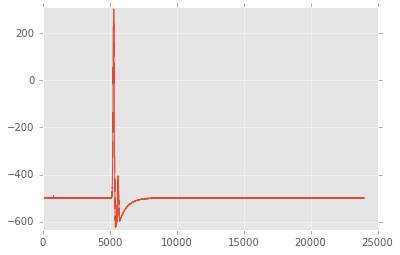

In [60]:
plts(pmtrd, signal_start=0, signal_end=25000, offset=10)

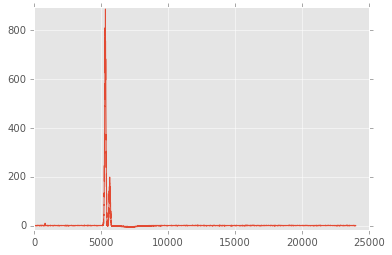

In [61]:
plts(pmtcw, signal_start=0, signal_end=25000, offset=10)

In [62]:
baseline = h5f.root.BLR.baseline

In [63]:
baseline

/BLR/baseline (EArray(10, 12), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1365, 12)

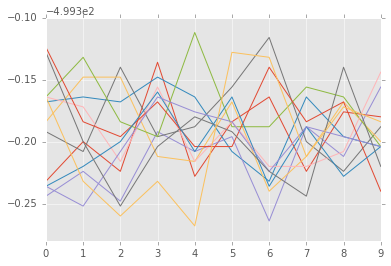

In [64]:
plt.plot(baseline)

In [65]:
print(baseline[0])

[-499.53201294 -499.46798706 -499.54400635 -499.49200439 -499.48400879
 -499.46398926 -499.46398926 -499.42401123 -499.53601074 -499.53601074
 -499.42800903 -499.46398926]


### Description of the BLR algorithm

1. The algorithm starts by computing the baseline, via a sliding MAU, which is initialized over the first few hundred samples.  

In [ ]:
#sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
#sblr.acum[nm] =  sblr.MAU[nm]
#sblr.BASELINE = sblr.MAU[nm-1]

1. The algorithm starts by computing the baseline, via a sliding MAU, which is initialized over the first few hundred samples.
2. A trigger line is defined adding a threshold (thr1) to the baseline defined by the MAU. 

In [ ]:
#for k in range(nm,len_signal_daq): 
#       trigger_line = sblr.MAU[k-1] + thr1

In [ ]:
plts(pmtrd, signal_start=5100, signal_end=5200, offset=10)

thr1 can be set at a number of sigmas above the noise. One can see in the plot above that the signal is up at about 10 counts. The noise ADC corresponds to 2-3 counts, thus 3 x Noise appears reasonable. 

The raw signal then raises up and eventually swings to negative values, due to the HPF of the FEE.

In [ ]:
plts(pmtrd, signal_start=5000, signal_end=6000, offset=10)

The algorithm will raise the flag pulse_on = 1 when the *raw signal* goes above threshold and will continue recovering signal while the *reconstructed signal* is positive, that is above a trheshold defined by the trigger line (and an optinal additional threshold, thr2, which can be taken equal to zero for well behaved signals). 

Once the reconstructed signal drops below zero, the flag for pulse_on is set to zero, and a second flag, wait_over is set to one. Wait_over=1 while the raw_signal is below the reconstructed signal minus a threshold (thr3). Notice that the reconstructed signal is near zero, but one must continue accumulating while the raw signal is negative. The raw signal has often a long tail. 

In [ ]:
#if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:

In [ ]:
plts(pmtrd, signal_start=6000, signal_end=8000, offset=10)

In essence, the BLR algorithm will stop accumulating when the raw signal reaches zero. 

##### Examples

##### High thresholds

In [ ]:
mau_len =250; thr1 = 20; thr2 = 0;  thr3 = 5; 

In [ ]:
%time sbl = BLR(pmtrd, coef[0], mau_len, thr1, thr2, thr3, "DEBUG")

In [ ]:
def plts(signal, signal_start=0, signal_end=1e+4, offset=5):

    ax1 = plt.subplot(1,1,1)
    ymin =np.amin(signal[signal_start:signal_end]) - offset
    ymax =np.amax(signal[signal_start:signal_end]) + offset
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([ymin, ymax])
    plt.plot(signal)


In [ ]:
plts(pmtrd, signal_start=5000, signal_end=8000, offset=50)

In [ ]:
plts(sbl.signal_r, signal_start=5000, signal_end=8000, offset=50)

In [ ]:
plts(sbl.pulse_on, signal_start=5000, signal_end=8000, offset=1)

##### NB: pulse_on =0 aroun 5400, but all the signal has not been recovered. The negative swing of the raw signal still will add a second pulse between 5400 and 5600 or so. wait over will switch on to 1. The algorithm has to keep track of whether the recovered signal is near zero (in which case the MAU is updated) or raises again, in which case the MAU is frozen. 

In [ ]:
#                     if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
#                         # raw signal still below recovered signal 
#                         # keep compensating pulse
#                         # is the recovered signal near offset?
#                         upper = offset + (thr3 + thr2)
#                         lower = offset - (thr3 + thr2)
                        
#                         if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
#                             # we are near offset, activate MAU. 
                            
#                             signal_i[k] = sblr.signal_r[k-1]
#                             sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
#                         else: 
#                             # rec signal not near offset MAU frozen  
#                             sblr.MAU[k] = sblr.MAU[k-1]
#                             signal_i[k] = sblr.MAU[k-1]
                            
#                         # keep adding recovered signal  
#                         sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
#                         sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
#                     else:  # raw signal above recovered signal: we are done 
                        
#                         wait_over = 0
#                         sblr.acum[k] = sblr.MAU[k-1]
#                         sblr.signal_r[k] = signal_daq[k]
#                         signal_i[k] = sblr.signal_r[k]
#                         sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm

#### Wait over until raw signal near zero

In [ ]:
plts(sbl.wait_over, signal_start=5150, signal_end=8000, offset=1)

In [ ]:
plts(sbl.offset, signal_start=0, signal_end=25000, offset=5)

In [ ]:
plts(sbl.trigger_line, signal_start=0, signal_end=25000, offset=5)

In [ ]:
plts(sbl.MAU, signal_start=0, signal_end=25000, offset=5)

In [ ]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

In [ ]:
plts(sbl.signal_r, signal_start=5000, signal_end=7500, offset=50)

In [ ]:
plts(sbl.acum, signal_start=5150, signal_end=8000, offset=50)

Notice the jump in the accumulator, near 7500. This is due to the thr3 being a bit too large

In [ ]:
plts(sbl.acum, signal_start=7400, signal_end=7500, offset=50)

In [ ]:
plts(sbl.signal_r, signal_start=5500, signal_end=10000, offset=5)

##### Notice the jump around 7500

In [ ]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

##### The jump is due to a too high level for thr3 which introduces a discontinuity when the raw and recovered signals approach each other

In [ ]:
epes = np.sum(pmttw)

In [ ]:
erec = np.sum(sbl.signal_r)

In [ ]:
epes

In [ ]:
erec

In [ ]:
erec/epes

In [ ]:
etmax = np.amax(pmttw)

In [ ]:
ermax = np.amax(sbl.signal_r)

In [ ]:
etmax

In [ ]:
ermax

In [ ]:
ermax/etmax

####  Low thresholds

In [ ]:
%time sbl = BLR(pmtrd, coef[0], 250, 5, 0, 1, "DEBUG")

In [ ]:
plts(sbl.pulse_on, signal_start=5150, signal_end=8000, offset=1)

In [ ]:
plts(sbl.wait_over, signal_start=5150, signal_end=25000, offset=1)

In [ ]:
plts(sbl.signal_r, signal_start=5000, signal_end=7500, offset=50)

In [ ]:
plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)

##### With a much lower threshold the accumulator ends up gracefully, but wait_over is always one, the raw and recovered signals never quite converge

In [ ]:
plts(sbl.acum, signal_start=9000, signal_end=25000, offset=50)

In [ ]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
erec = np.sum(sbl.signal_r)

In [ ]:
erec

In [ ]:
erec/epes

##### We recover almost 50 % more signal. This is clearly a fake, due to the fact that both signals oscilate around zero and we keep adding to the accumulator

### Using noise as criterium to set thresholds

##### Measured adc noise

In [ ]:
FP.NOISE_ADC

In [ ]:
%time sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = 0, thr3 = FP.NOISE_ADC, log='INFO')

In [ ]:
plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)

In [ ]:
plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)

##### The signal ends now nicely. 

In [ ]:
plts(sbl.signal_r, signal_start=5000, signal_end=7500, offset=50)

In [ ]:
plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)

In [ ]:
plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)

##### There is still a jump in the accumulator, but smaller

##### NB! getting wait_over to zero has a cost in the accumulator

In [ ]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

##### But the recovered signal is flatter

In [ ]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

In [ ]:
%time sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = 1*FP.NOISE_ADC, thr2 = 0, thr3 = FP.NOISE_ADC, log='INFO')

In [ ]:
plts(sbl.signal_r, signal_start=5000, signal_end=8500, offset=50)

In [ ]:
plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)

In [ ]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

In [ ]:
erec = np.sum(sbl.signal_r)

In [ ]:
erec

In [ ]:
erec/epes

In [ ]:
emax = np.amax(sbl.signal_r)

In [ ]:
emax

In [ ]:
epsm = np.amax(pmttw)

In [ ]:
epsm

In [ ]:
emax/epsm

#### Fine tuning near threshold. 

When the recovered signal is near threshold, one can in principle use thr2 to fine-tue the algorithm, so that the MAU is updated near threshold, allowing for a better track of the baseline. 

In [ ]:
%time sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = FP.NOISE_ADC, thr3 = FP.NOISE_ADC, log='INFO')

In [ ]:
plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)


In [ ]:
plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)


In [ ]:
plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)


In [ ]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

In [ ]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=25)
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=25)


#####  The effect of thr2 seems to be negligible. 

In [ ]:
plts(sbl.signal_r, signal_start=8000, signal_end=20000, offset=2)

##### The recovered signal oscillates around zero, as it should be, adding the tail to the signal should be a net effect of near zero. We can study this by computing the energy of the signal while pulse_on =1 and wait_over = 1

In [ ]:
erec = np.sum(sbl.signal_r)

In [ ]:
erec

In [ ]:
erec/epes

In [ ]:
#energy = np.dot(pulse_f,(signal_r-BASELINE)) 

##### First we recompute the energy subtracting the Baseline. 

In [ ]:
erec = np.sum(sbl.signal_r - sbl.BASELINE)

In [ ]:
erec

In [ ]:
erec/epes

##### Now we require that pulse_on =1 or wait_over = 1

In [ ]:
erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)

In [ ]:
erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)

In [ ]:
erec = erec1 + erec2

In [ ]:
erec1

In [ ]:
erec2

In [ ]:
erec

In [ ]:
erec/epes

##### Notice that we recover a bit more of signal if we do not add the tail (slight negative swing)

### What is the dependence of the recovered signal with the value of thresholds? (number of sigmas)

In [ ]:
def blr_mp(nsigma1=3,nsigma2=1):
    """
    A Marco Polo function to study the dependence of BLR with thresholds
    """
    sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = nsigma1*FP.NOISE_ADC, 
              thr2 = 0, thr3 = nsigma2*FP.NOISE_ADC, log='INFO')
    
    plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)
    plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)
    plt.show()
    plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=5000, signal_end=9500, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(sbl.signal_r, signal_start=8000, signal_end=20000, offset=2)
    plt.show()
    plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(pmtrd, signal_start=8000, signal_end=20000, offset=5)
    plt.show()
    erec_a = np.sum(sbl.signal_r)
    erec_b = np.sum(sbl.signal_r - sbl.BASELINE)
    erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
    erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
    erec_c = erec1 + erec2
    print("erec_a = {}, erec_b = {}, erec_c = {}".format(erec_a,erec_b,erec_c))
    print("erec_1 = {}, erec_2 = {}".format(erec1,erec2))
    
    


    
    

In [ ]:
blr_mp(nsigma1=3,nsigma2=1)

In [ ]:
blr_mp(nsigma1=4,nsigma2=1)

In [ ]:
blr_mp(nsigma1=5,nsigma2=1)

In [ ]:
n_5_3 = 109598.6546/110882.442971

In [ ]:
n_5_3

##### changing the number of sigmas from 3 to 5 introduces a variation of 0.6 per mil. Thus the cut is robust

In [ ]:
blr_mp(nsigma1=2,nsigma2=2)

In [ ]:
n_3_3_2 = 110403.159327/110882.442971

In [ ]:
n_3_3_2

##### The variation is now 5 parts per mil and a clear discontinuity is seen. The threshold thr3 cannot be too high!

In [ ]:
blr_mp(nsigma1=2,nsigma2=0.5)

##### Lowering the threshold too much implies that wait_over = 1 all the time and we keep accumulating even when the raw signal is near zero.

In [ ]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

#### IN CONCLUSION: the algo seems robust setting thr1 = 3 * sigma, thr2 = 0, thr3 = 1* sigma, where sigma is the rms of the noise. It also appears robust at thr1 = sigma, thr2 = sigma

### Looking at all PMTs in the event

In [ ]:
def blr12(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=0):
    """
    BLR algorithm for the 12 PMTs in the EP
    pmtrwf.shape = (nof_events, nof_sensors, wf_length)
    """
    NPMT = pmtrwf.shape[1]
    EREC=[]
    ER = []
    SBL =[]
    ETRUE = []
    E={}
    for i in range(NPMT):
        pmtrd = pmtrwf[event_number, i]
        sbl = BLR(pmtrd, coef[i], mau_len=250, thr1 = nsigma1*FP.NOISE_ADC, 
              thr2 = 0, thr3 = nsigma2*FP.NOISE_ADC, log='INFO')
        
        erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
        erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
        erec = erec1 + erec2
        EREC.append(erec)
        ETRUE.append(epmt[event_number,i])
        ER.append(erec/epmt[event_number,i])
        SBL.append(sbl)
    E['etrue'] = ETRUE
    E['erec'] = EREC
    E['eratio'] = ER
    return pd.DataFrame(E), SBL
        

In [ ]:
%time eDF, SBL = blr12(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=0)

In [ ]:
eDF

In [ ]:
eDF.describe()

In [ ]:
error = 0.07/18.7

In [ ]:
error*1000.

### Ratio between true and reconstructed energy in the PMTs 

The Ratio between true and reconstructed energy in the PMTs must be a good estimator of the uncertainties introduced by the BLR algorithm. For arbitrary events, the energy in each PMT is different (due to geometrical effects) but the ratio between true en reconstructed energy must be the same. For event zero we can see that the std of the ratio is 007, thus std/mean implies a relative error short of 4 per mil which appears acceptable. 

### Iterating over events

In [ ]:
def blr_er(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, first_event=0, last_event=10):
    """
    BLR algorithm for the 12 PMTs in the EP
    pmtrwf.shape = (nof_events, nof_sensors, wf_length)
    """
    NPMT = pmtrwf.shape[1]
    E={}
    for iev in range(first_event,last_event):
        ER = []
        for i in range(NPMT):
            pmtrd = pmtrwf[iev, i]
            sbl = BLR(pmtrd, coef[i], mau_len=250, thr1 = nsigma1*FP.NOISE_ADC, 
                      thr2 = 0, thr3 = nsigma2*FP.NOISE_ADC, log='INFO')
        
            erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
            erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
            erec = erec1 + erec2
        
            ER.append(erec/epmt[iev,i])
        
        E[iev] = ER
   
    return pd.DataFrame(E)

In [ ]:
%time edf = blr_er(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, first_event=0, last_event=10)

In [ ]:
edf

In [ ]:
edf.describe()

##### Notice that event = 5 has a lower ratio than all others. Let us examine this event in more detail

In [ ]:
def blr12_mp(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=5, pmt_number=0):
    """
    A Marco Polo function to examine events
    """
    eDF, SBL = blr12(pmtrwf, epmt, coef, nsigma1, nsigma2, event_number)
    return eDF, SBL
    
    #blr12_plt(eDF.ix[event_number],SBL[event_number],pmtrwf[event_number, pmt_number])

def blr12_plt(edf,sbl,pmtrd):
    """
    plot interesting stuff
    """
    plts(pmtrd, signal_start=0, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=0, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)
    plt.show()
    plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)
    plt.show()
    plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=5000, signal_end=9500, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(sbl.signal_r, signal_start=8000, signal_end=20000, offset=2)
    plt.show()
    plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(pmtrd, signal_start=8000, signal_end=20000, offset=5)
    plt.show()
    erec_a = np.sum(sbl.signal_r)
    erec_b = np.sum(sbl.signal_r - sbl.BASELINE)
    erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
    erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
    erec_c = erec1 + erec2
    print("erec_a = {}, erec_b = {}, erec_c = {}".format(erec_a,erec_b,erec_c))
    print("erec_1 = {}, erec_2 = {}".format(erec1,erec2))
    print("edf = {}".format(edf))
    

In [ ]:
eDF, SBL = blr12_mp(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=5, pmt_number=0)

In [ ]:
event_number=5; pmt_number=0

In [ ]:
blr12_plt(eDF.ix[event_number],SBL[event_number],pmtrwf[event_number, pmt_number])

#####  The event is a very small signal. Study in detail

In [ ]:
plts(pmtrwf[5, 0], signal_start=7000, signal_end=10000, offset=10)

In [ ]:
sbl = SBL[0]

In [ ]:
plts(sbl.pulse_on, signal_start=7000, signal_end=10000, offset=1)


In [ ]:
plts(sbl.wait_over, signal_start=7000, signal_end=10000, offset=1)

In [ ]:
plts(sbl.signal_r, signal_start=7000, signal_end=10000, offset=10)

In [ ]:
plts(sbl.signal_r, signal_start=8500, signal_end=10000, offset=10)

In [ ]:
plts(pmtrwf[5, 0], signal_start=8500, signal_end=10000, offset=10)

In [ ]:
plts(pmttwf[5, 0], signal_start=0, signal_end=25000, offset=10)

In [ ]:
plts(pmttwf[0, 0], signal_start=0, signal_end=25000, offset=10)

In [ ]:
epmt

In [ ]:
epmt[5,0]

In [ ]:
epmt[0,0]

####  The algorithm appears to work well, but clearly the accuracy in the reconstruction depends on the intensity of the signal, for event 5 the true signal is about 20 times smaller than for event 0

In [ ]:
plts(pmtrwf[5, 0], signal_start=7800, signal_end=8200, offset=10)

In [ ]:
plts(sbl.pulse_on, signal_start=7800, signal_end=8200, offset=1)

In [ ]:
plts(sbl.signal_r, signal_start=7800, signal_end=8200, offset=10)

In [ ]:
plts(pmtrwf[5, 0], signal_start=8200, signal_end=9500, offset=10)

In [ ]:
plts(sbl.wait_over, signal_start=8200, signal_end=9500, offset=2)

In [ ]:
plts(sbl.signal_r, signal_start=8200, signal_end=9500, offset=10)

##### Signal appears perfectly recovered. Perhaps cutoff too high?

In [ ]:
%time edf = blr_er(pmtrwf, epmt, coef, nsigma1 = 2, nsigma2 =1, first_event=0, last_event=10)

In [ ]:
edf

In [ ]:
edf.describe()

In [ ]:
%time edf = blr_er(pmtrwf, epmt, coef, nsigma1 = 1, nsigma2 =1, first_event=0, last_event=10)

In [ ]:
edf

In [ ]:
edf.describe()

###  LOW CUTOFFs appear to be the best strategy!

In [ ]:
import FEParam as FP

In [ ]:
from scipy import signal as SGN

#### Inverse signal

In [ ]:
len_WF = pmtrwf.shape[2]

In [ ]:
signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

In [ ]:
def inverse_signal(pmtrd_,signal_t, event_number,CA):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(len_WF, dtype=np.int32)
    
    inv = []
    for j in range(NPMT):
        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        inv.append( signal_inv_daq)
    return pd.Series(inv)

In [ ]:
idf = inverse_signal(pmtrwf,signal_t,event_number = 0, CA=FP.C12)

In [ ]:
idf

In [ ]:
def plot_inverse(wfdf):
    """
    plot the inverse function
    """
    
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        wf = wfdf.ix[i]
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len(wf)])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(wf[1:])

    plt.show()

In [ ]:
plot_inverse(idf)

### ISIDORA DRIVER

In [ ]:
from Configure import configure

In [ ]:
from cities import isidora

In [ ]:
def ISIDORA(argv):
    INFO, CFP = configure(argv[0],argv[1:])
    if INFO:
        print(isidora)

    wait()
    
    print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    
    PATH_IN=CFP['PATH_IN'] 
    FILE_IN=CFP['FILE_IN']
    FIRST_EVT=CFP['FIRST_EVT']
    LAST_EVT=CFP['LAST_EVT']
    RUN_ALL=CFP['RUN_ALL']
    COEF=CFP['COEF']
    CA=farray_from_string(CFP['CA'])*nF 
    AC=farray_from_string(CFP['AC']) 
    MAU_LEN=CFP['MAU_LEN']
    NSIGMA1=CFP['NSIGMA1'] 
    NSIGMA2=CFP['NSIGMA2'] 

    NEVENTS = LAST_EVT -  FIRST_EVT


    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("MAU length = {} n_sigma1 = {} n_sigma2 = {} ".format(
        MAU_LEN,NSIGMA1,NSIGMA2))
    logger.info("CA sigma(nf) = {}  ".format(CA/nF))
    

    # open the input file in mode append 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "a") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.RD.pmtrwf

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)    
        
        NPMT = pmtrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof events in input DST = {} ".format(
        NPMT,NEVENTS_DST))

        logger.info("lof PMT WF (MC) = {} ".format(
        PMTWL))

        wait()
            
        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        pmtcwf =0
        try:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration (por PMT0)

        rgroup = 0
        try:
            rgroup = h5in.root.BLR
            
        except tables.exceptions.NodeError:
            rgroup = h5in.create_group(h5in.root, "BLR")

        
        MAU = 0
        acum = 0
        pulse_on = 0
        wait_over = 0

        try:
            mau = h5in.root.BLR.mau
            h5in.remove_node("/BLR","mau")
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            pulse_on = h5in.root.BLR.pulse_on
            h5in.remove_node("/BLR","pulse_on")
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            wait_over = h5in.root.BLR.wait_over
            h5in.remove_node("/BLR","wait_over")
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            acum  = h5in.root.BLR.acum 
            h5in.remove_node("/BLR","acum")
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)

            
        if NEVENTS > NEVENTS_DST and RUN_ALL == False:
            print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
            sys.exit(0)

        elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
            FIRST_EVT = 0
            LAST_EVT = NEVENTS_DST
            NEVENTS = NEVENTS_DST

            
        for i in range(FIRST_EVT,LAST_EVT):
            
            logger.info("-->event number ={}".format(i))

            #DBLR
            coeff_acc = AC
            if COEF == 0:
                coeff_acc = accumulator_coefficients(pmtrd_,CA)


            BLRS = DBLR(pmtrd_, i, coeff_acc, mau_len=MAU_LEN,
                        thr1 = NSIGMA1*FP.NOISE_ADC, thr2=0, 
                        thr3 = NSIGMA2*FP.NOISE_ADC, log='INFO')

            
            pmtCWF = []
            for blr in BLRS:
                pmtCWF.append(blr.signal_r)
                
            #append to pmtcwd
            pmtcwf.append(np.array(pmtCWF).reshape(1, NPMT, PMTWL))

            # append BLR variables

            mau_pmt0 = BLRS[0].MAU
            mau.append(mau_pmt0.reshape(1, PMTWL))

            pulse_on0 = BLRS[0].pulse_on
            pulse_on.append(pulse_on0.reshape(1, PMTWL))

            wait_over0 = BLRS[0].wait_over
            wait_over.append(wait_over0.reshape(1, PMTWL))

            acum0  = BLRS[0].acum
            acum.append(acum0.reshape(1, PMTWL))
                
                
        pmtcwf.flush()
        mau.flush()
        pulse_on.flush()
        wait_over.flush()
        acum.flush()
        

    print("Leaving Isidora. Safe travels!")

          

### The energy criteria

1. Cannot use only pulse_over = 1 (event 0 shows that the algorithm does not identify the second pulse as a pulse on, but as a wait-over (e.g, signal recovery).
2. Take as energy all the wait_over tail is probably prone to add zeros. Not good idea either, I think. 
3. Possibly best is to find peaks in the reconstructed signal and then add the energy

In [ ]:
plts(pmtcwf[0, 0], signal_start=6000, signal_end=9000, offset=5)

Not smart to keep adding numbers close to zero!

### Plotting sensor energy

In [ ]:
from PandaUtil import *

In [ ]:
h5f = tb.open_file('../../data/Waveforms/25ns/WF_Na_test_RWF.h5', "r+")

In [ ]:
geom_t = h5f.root.Detector.DetectorGeometry

In [ ]:
geom_df = read_data_geom(geom_t)

In [ ]:
geom_df

In [ ]:
pmt_t = h5f.root.Sensors.DataPMT
sipm_t = h5f.root.Sensors.DataSiPM

In [ ]:
pmtdf = read_data_sensors(pmt_t)

In [ ]:
sipmdf = read_data_sensors(sipm_t)

In [ ]:
pmtdf

In [ ]:
epmt

In [ ]:
def plot_ene_pmt(geom_df,sensor_df, epmt, event_number=0, radius=10):
    """
    plots the reconstructed energy of the PMTs
    energy_se is a series describing the reconstructed energy 
    in each PMT
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    col = epmt[event_number] 
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    circles(x, y, r, c=col, alpha=0.5, ec='none')
    plt.colorbar()
    #xlim(-198,198)  #one should use geom info
    #ylim(-198,198)
    xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    return col

In [ ]:
plot_ene_pmt(geom_df,pmtdf, epmt, event_number = 0, radius=10)

In [ ]:
plot_ene_pmt(geom_df,pmtdf, epmt, event_number = 1, radius=10)

In [ ]:
plot_ene_pmt(geom_df,pmtdf, epmt, event_number = 3, radius=10)